# Struttura dei test

Di seguito un'analisi sulle performance del modulo implementato (PPGA). Andremo
quindi a confrontare:

- Versione sequenziale e versione parallela di PPGA.
- Confronto tra PPGA e DEAP (sequenziale e parallelo).
- Considerazioni finali sul problema specifico del paper per un corretto
  utilizzo della versione parallela ed evitare comportamenti inattesi.

I benchmark sono stati effettuati su una macchina con doppio processore AMD
EPYC 7313, ciascuno dei quali a 16 core con frequenza di clock massima a 3.7
GHz. Il problema di riferimento è quello di explainability in cui è stato
eseguito l'algoritmo genetico su un solo punto del dataset (32 features) e su
una sola classe target. I parametri presi in considerazione sono:

- **Modello di ML**: RandomForestClassifier, SVC e MLPClassifier.
- **Numero di individui sintetici**: 1000, 2000, 4000, 8000, 16000.
- **Numero di worker**: 1, 2, 4, 8, 16, 32. Le esecuzioni con 1 worker
  corrispondono in realtà alla versione sequenziale dell'algoritmo.

Sono state esplorate tutte le possibili combinazioni di tali parametri e, per
ciascuna di esse sono stati eseguiti 10 test compiendo 5 iterazioni
dell'algoritmo. I risultati dei 10 test sono stati poi aggregati prendendo
media e deviazione standard dei tempi registrati.

Per PPGA sono stati misurati sia il tempo d'esecuzione totale, sia il tempo
specifico speso in parallelo, che, ossia quello che comprende le fasi di
crossover, mutazione e valutazione e sincronizzazione tra i worker.

Per DEAP è stato misurato solo il tempo di esecuzione totale dell'algoritmo,
portando quindi ad un confronto tra i due solo su quest'ultima misurazione
e valori derivati.

# Analisi PPGA

Per prima cosa si vogliono paragonare le prestazioni offerte dalla versione
parallela dell'algoritmo rispetto a alla sua versione sequenziale.


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

ppga_df = pd.read_csv("../results/ppga_benchmark_32.csv")
ppga_df

,classifier,population_size,workers,time,time_std,ptime,ptime_std
0,RandomForestClassifier,1000,1,16.071994,0.092577,16.012568,0.092652
1,RandomForestClassifier,1000,2,8.558658,0.064458,8.381711,0.064899
2,RandomForestClassifier,1000,4,4.458123,0.042222,4.253589,0.047309
3,RandomForestClassifier,1000,8,2.578786,0.076705,2.332122,0.066215
4,RandomForestClassifier,1000,16,1.905234,0.084589,1.563598,0.082070
...,...,...,...,...,...,...,...
85,MLPClassifier,16000,2,6.343140,0.160284,5.156604,0.155495
86,MLPClassifier,16000,4,4.065129,0.130653,2.844911,0.095685
87,MLPClassifier,16000,8,3.068803,0.167028,1.729377,0.104160
88,MLPClassifier,16000,16,2.818851,0.171505,1.267870,0.088590


In [34]:
ppga_df[ppga_df["classifier"] == "RandomForestClassifier"]

,classifier,population_size,workers,time,time_std,ptime,ptime_std
0,RandomForestClassifier,1000,1,16.071994,0.092577,16.012568,0.092652
1,RandomForestClassifier,1000,2,8.558658,0.064458,8.381711,0.064899
2,RandomForestClassifier,1000,4,4.458123,0.042222,4.253589,0.047309
3,RandomForestClassifier,1000,8,2.578786,0.076705,2.332122,0.066215
4,RandomForestClassifier,1000,16,1.905234,0.084589,1.563598,0.082070
5,RandomForestClassifier,1000,32,1.892703,0.093802,1.289897,0.055379
6,RandomForestClassifier,2000,1,32.837735,0.321354,32.708643,0.306003
7,RandomForestClassifier,2000,2,16.929139,0.132439,16.685875,0.127242
8,RandomForestClassifier,2000,4,8.837405,0.080220,8.544220,0.070648
9,RandomForestClassifier,2000,8,4.809912,0.078537,4.467385,0.058920


## Tempo d'esecuzione

Come si può notare, il dataframe contiene una colonna "time" e una colonna
"ptime". Le prima indica il tempo d'esecuzione totale, la seconda il tempo
di esecuzione delle sole fasi eseguite in parallelo.

Di seguito un grafico che riporta l'andamento del tempo d'esecuzione in
funzione del diverso numero di worker e su diverse dimensioni dell'input.


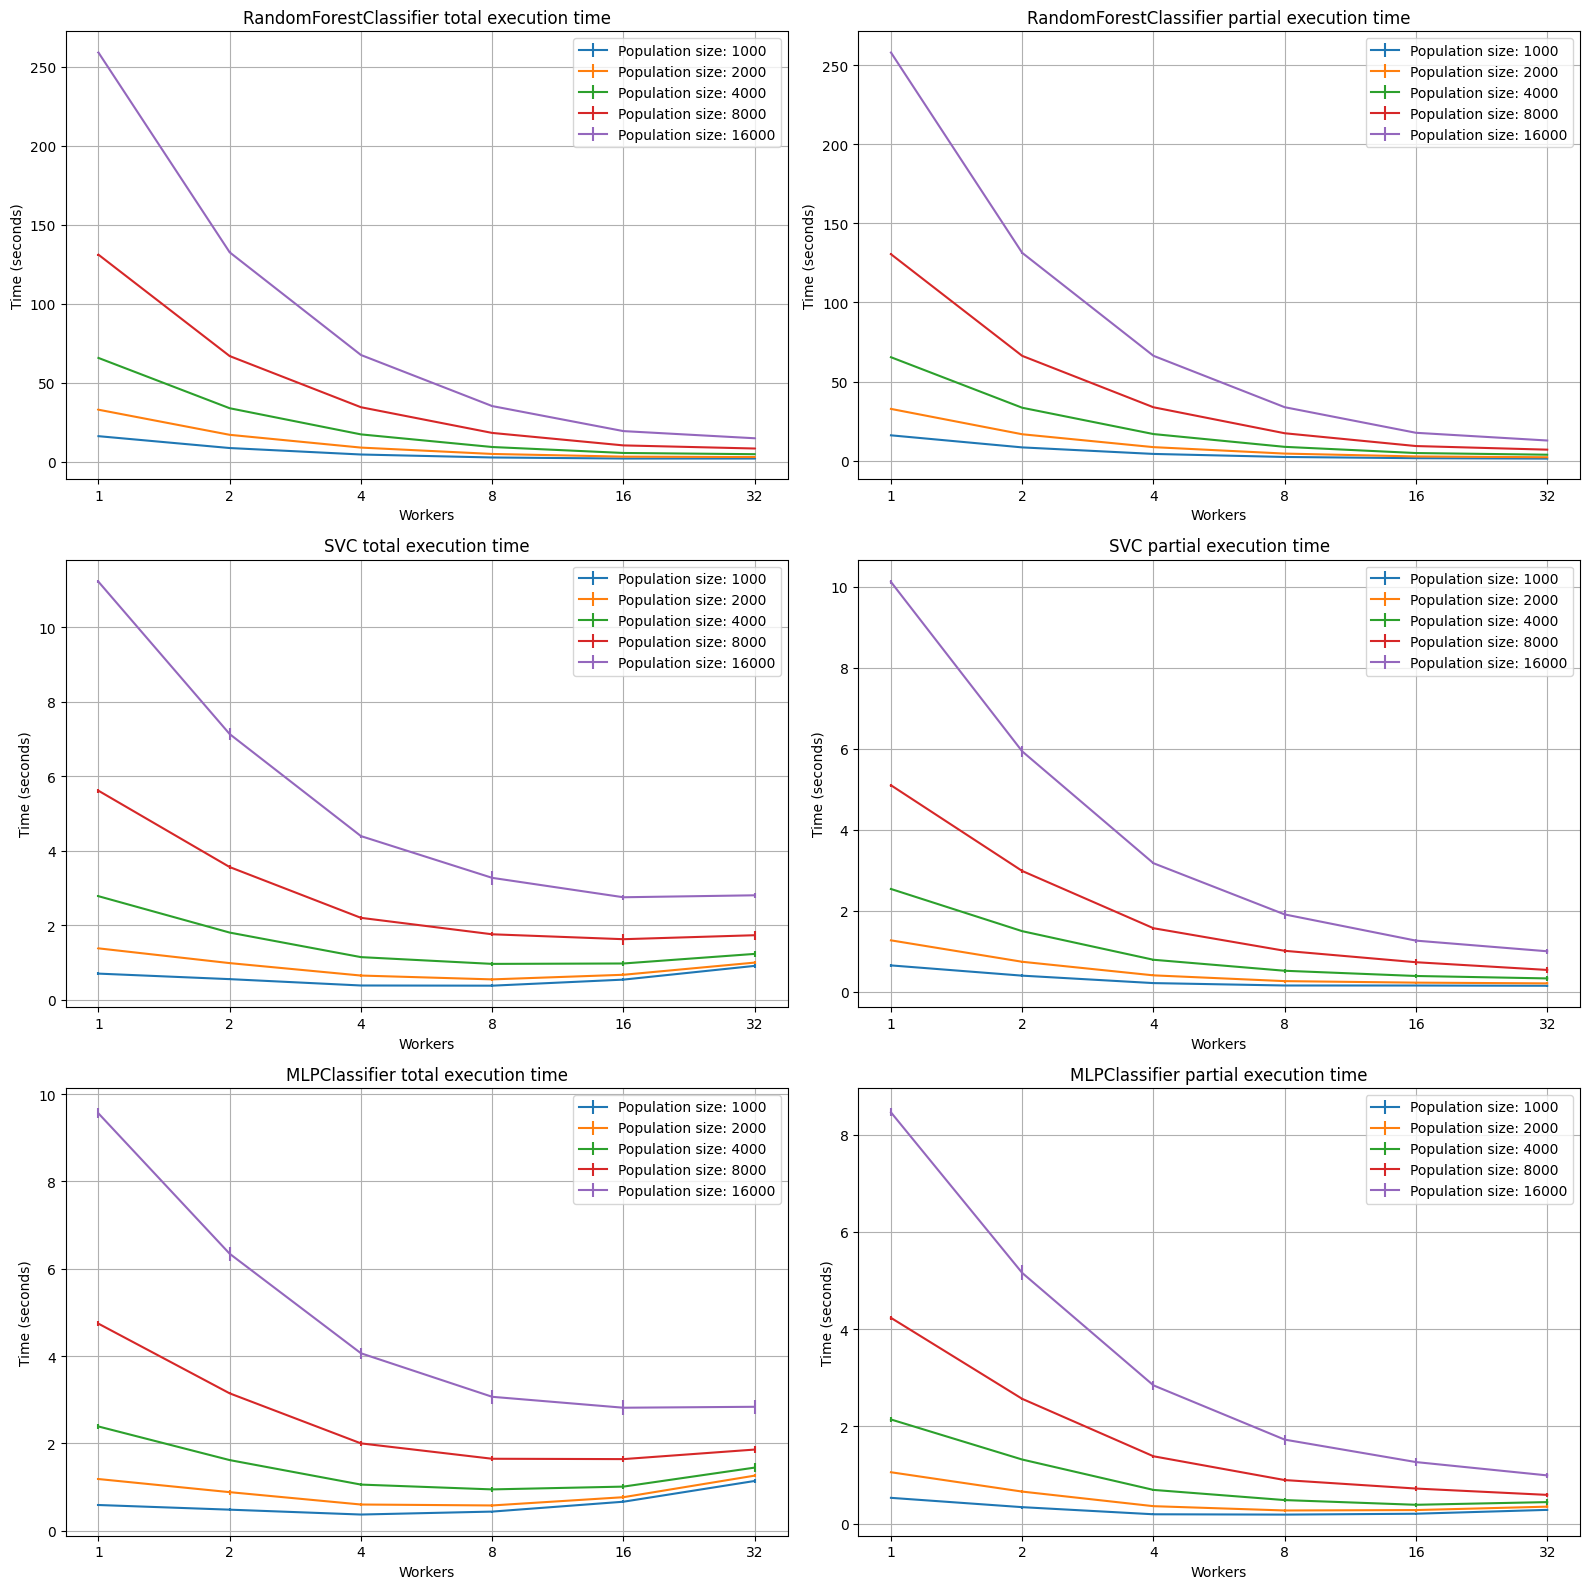

In [35]:
models = ppga_df["classifier"].unique()
workers = ppga_df["workers"].unique()
population_sizes = ppga_df["population_size"].unique()

fig, axes = plt.subplots(3, 2, figsize=(16, 16))

for i, model in enumerate(models):
    for ps in population_sizes:
        mask = (ppga_df["classifier"] == model) & (ppga_df["population_size"] == ps)
        axes[i][0].set_title(f"{model} total execution time")
        axes[i][0].set_xlabel("Workers")
        axes[i][0].set_ylabel("Time (seconds)")
        axes[i][0].errorbar(
            workers,
            ppga_df[mask]["time"].values,
            ppga_df[mask]["time_std"],
            label=f"Population size: {ps}",
        )

        axes[i][0].set_xscale("log", base=2)
        axes[i][0].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
        axes[i][0].grid()
        axes[i][0].legend()

        axes[i][1].set_title(f"{model} partial execution time")
        axes[i][1].set_xlabel("Workers")
        axes[i][1].set_ylabel("Time (seconds)")
        axes[i][1].errorbar(
            workers,
            ppga_df[mask]["ptime"].values,
            ppga_df[mask]["ptime_std"],
            label=f"Population size: {ps}",
        )

        axes[i][1].set_xscale("log", base=2)
        axes[i][1].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
        axes[i][1].grid()
        axes[i][1].legend()

plt.tight_layout()
plt.show()


## Speed up

Procediamo con il calcolare lo _speed up_ ottenuto per ogni modello e per ogni
numero di individui sintetici. Anche qui viene calcolato sia lo speed up
ottenuto sull'esecuzione dell'intero algoritmo, sia quello ottenuto solo sulla
parte parallelizzata.


In [36]:
reference_times = ppga_df[ppga_df["workers"] == 1].set_index(
    ["classifier", "population_size"]
)["time"]

ppga_df["speed_up"] = ppga_df.apply(
    lambda row: reference_times.loc[(row["classifier"], row["population_size"])]
    / row["time"],
    axis=1,
)

reference_ptimes = ppga_df[ppga_df["workers"] == 1].set_index(
    ["classifier", "population_size"]
)["ptime"]

ppga_df["pure_speed_up"] = ppga_df.apply(
    lambda row: reference_ptimes.loc[(row["classifier"], row["population_size"])]
    / row["ptime"],
    axis=1,
)

ppga_df

,classifier,population_size,workers,time,time_std,ptime,ptime_std,speed_up,pure_speed_up
0,RandomForestClassifier,1000,1,16.071994,0.092577,16.012568,0.092652,1.000000,1.000000
1,RandomForestClassifier,1000,2,8.558658,0.064458,8.381711,0.064899,1.877864,1.910417
2,RandomForestClassifier,1000,4,4.458123,0.042222,4.253589,0.047309,3.605104,3.764484
3,RandomForestClassifier,1000,8,2.578786,0.076705,2.332122,0.066215,6.232387,6.866093
4,RandomForestClassifier,1000,16,1.905234,0.084589,1.563598,0.082070,8.435708,10.240846
...,...,...,...,...,...,...,...,...,...
85,MLPClassifier,16000,2,6.343140,0.160284,5.156604,0.155495,1.506793,1.640045
86,MLPClassifier,16000,4,4.065129,0.130653,2.844911,0.095685,2.351167,2.972699
87,MLPClassifier,16000,8,3.068803,0.167028,1.729377,0.104160,3.114503,4.890238
88,MLPClassifier,16000,16,2.818851,0.171505,1.267870,0.088590,3.390671,6.670293


Di seguito vari grafici per vedere l'andamento dello speed up in relazione
al numero di individui sintetici generati. Sulla sinistra lo speed up ottenuto
sull'intero algoritmo, mentre sulla sinistra lo speed up ottenuto sulla sola
parte parallelizzata.

In entrambi i casi è stata tracciata anche la linea rappresentante lo speed up
ideale.

Nel caso in cui si considera solo la parte tratteggiata viene considerato
"ideale" uno speed up lineare. Ci aspettiamo quindi un valore $n$ se
impieghiamo $n$ worker per il lavoro.

Nel caso in cui si considera il tempo d'esecuzione globale dell'algoritmo
dobbiamo considerare che le fasi non parallelizzate non otterranno alcuno
speed up e dunque lo speed up ideale sarà calcolato come il rapporto tra
il tempo impiegato dall'algoritmo sequenziale e il tempo impiegato
dall'algoritmo parallelo, assumendo che la parte parallelizzata goda di uno
speed up lineare. Sia quindi

$$t_s = r + cme$$

il tempo impiegato dalla versione sequenziale, composto dal tempo impiegato
dalle fasi di crossover, mutazione e valutazione ($cme$) e dal resto
dell'algoritmo ($r$). Il tempo ideale impiegato dalla versione parallela con
$n$ worker sarà

$$t_p = r + \frac{cme}{n}$$

Segue quindi che lo speed up atteso sarà

$$\frac{t_s}{t_p} = \frac{r + cme}{r + \frac{cme}{n}}$$


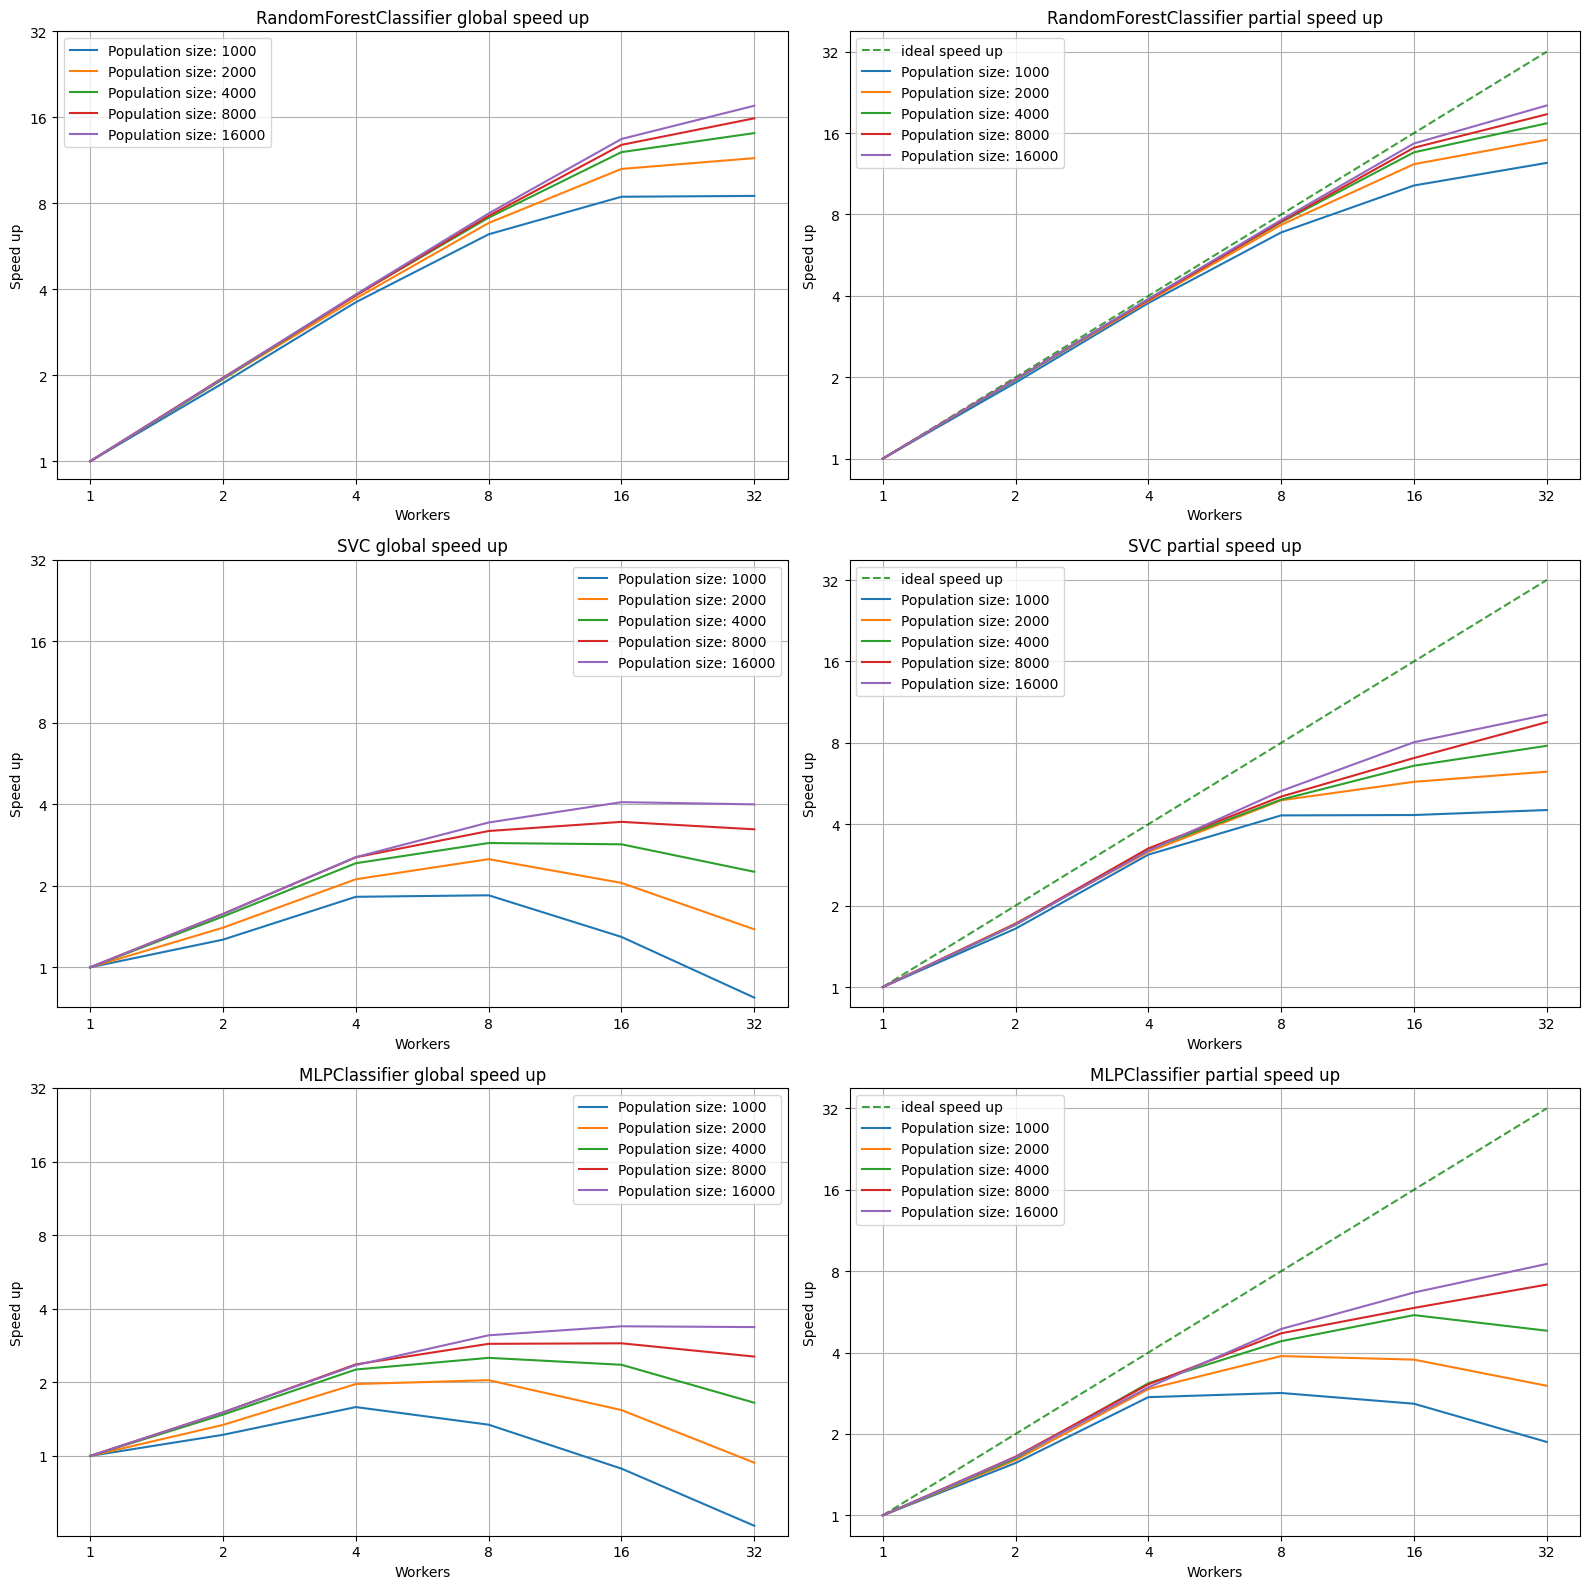

In [37]:
models = ppga_df["classifier"].unique()
workers = ppga_df["workers"].unique()
population_sizes = ppga_df["population_size"].unique()

fig, axes = plt.subplots(3, 2, figsize=(16, 16))

for i, model in enumerate(models):
    axes[i][1].plot(workers, workers, "g--", alpha=0.75, label="ideal speed up")
    for ps in population_sizes:
        mask = (ppga_df["classifier"] == model) & (ppga_df["population_size"] == ps)
        axes[i][0].set_title(f"{model} global speed up")
        axes[i][0].set_xlabel("Workers")
        axes[i][0].set_ylabel("Speed up")
        axes[i][0].errorbar(
            workers,
            ppga_df[mask]["speed_up"].values,
            label=f"Population size: {ps}",
        )

        axes[i][0].set_xscale("log", base=2)
        axes[i][0].set_yscale("log", base=2)
        axes[i][0].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
        axes[i][0].set_yticks(workers, labels=[int(2**w) for w in np.log2(workers)])
        axes[i][0].grid()
        axes[i][0].legend()

        axes[i][1].set_title(f"{model} partial speed up")
        axes[i][1].set_xlabel("Workers")
        axes[i][1].set_ylabel("Speed up")
        axes[i][1].errorbar(
            workers,
            ppga_df[mask]["pure_speed_up"].values,
            label=f"Population size: {ps}",
        )

        axes[i][1].set_xscale("log", base=2)
        axes[i][1].set_yscale("log", base=2)
        axes[i][1].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
        axes[i][1].set_yticks(workers, labels=[int(2**w) for w in np.log2(workers)])
        axes[i][1].grid()
        axes[i][1].legend()

plt.tight_layout()
plt.show()

Come è facile notare, il Random Forest, che è anche il più lento, è quello che
trae più beneficio da una parallelizzazione più pesante. Gli altri modelli
sono molto più performanti in fase di predizione ed è quindi più difficile
ottenere un valore di speed up vicino al numero di worker utilizzati.

## Stabilità

Come ultima analisi vorrei valutare la stabilità delle performance
dell'algoritmo stesso andando a calcolare il coefficiente di variazione
del tempo impiegato. Andiamo quindi a calcolare

$$\frac{\sigma}{\mu}$$

dove $\mu$ e $\sigma$ sono media e deviazione standard dei tempi d'esecuzione
ottenuti da 10 prove ripetute dello stesso test. Questo dovrebbe darci indicare
approssimativamente quanto sia facile prevedere il tempo d'esecuzione
dell'algoritmo.


In [38]:
ppga_df["var_coeff"] = ppga_df["time_std"] / ppga_df["time"]
ppga_df

,classifier,population_size,workers,time,time_std,ptime,ptime_std,speed_up,pure_speed_up,var_coeff
0,RandomForestClassifier,1000,1,16.071994,0.092577,16.012568,0.092652,1.000000,1.000000,0.005760
1,RandomForestClassifier,1000,2,8.558658,0.064458,8.381711,0.064899,1.877864,1.910417,0.007531
2,RandomForestClassifier,1000,4,4.458123,0.042222,4.253589,0.047309,3.605104,3.764484,0.009471
3,RandomForestClassifier,1000,8,2.578786,0.076705,2.332122,0.066215,6.232387,6.866093,0.029745
4,RandomForestClassifier,1000,16,1.905234,0.084589,1.563598,0.082070,8.435708,10.240846,0.044398
...,...,...,...,...,...,...,...,...,...,...
85,MLPClassifier,16000,2,6.343140,0.160284,5.156604,0.155495,1.506793,1.640045,0.025269
86,MLPClassifier,16000,4,4.065129,0.130653,2.844911,0.095685,2.351167,2.972699,0.032140
87,MLPClassifier,16000,8,3.068803,0.167028,1.729377,0.104160,3.114503,4.890238,0.054428
88,MLPClassifier,16000,16,2.818851,0.171505,1.267870,0.088590,3.390671,6.670293,0.060842


In questo modo è possibile vedere la stabilità dell'algoritmo al variare di
parametri come numero di worker e dimensioni della popolazione. Come soglia
per separare i test più stabili dagli altri ho scelto un valore del 10% per
il coefficiente di variabilità.


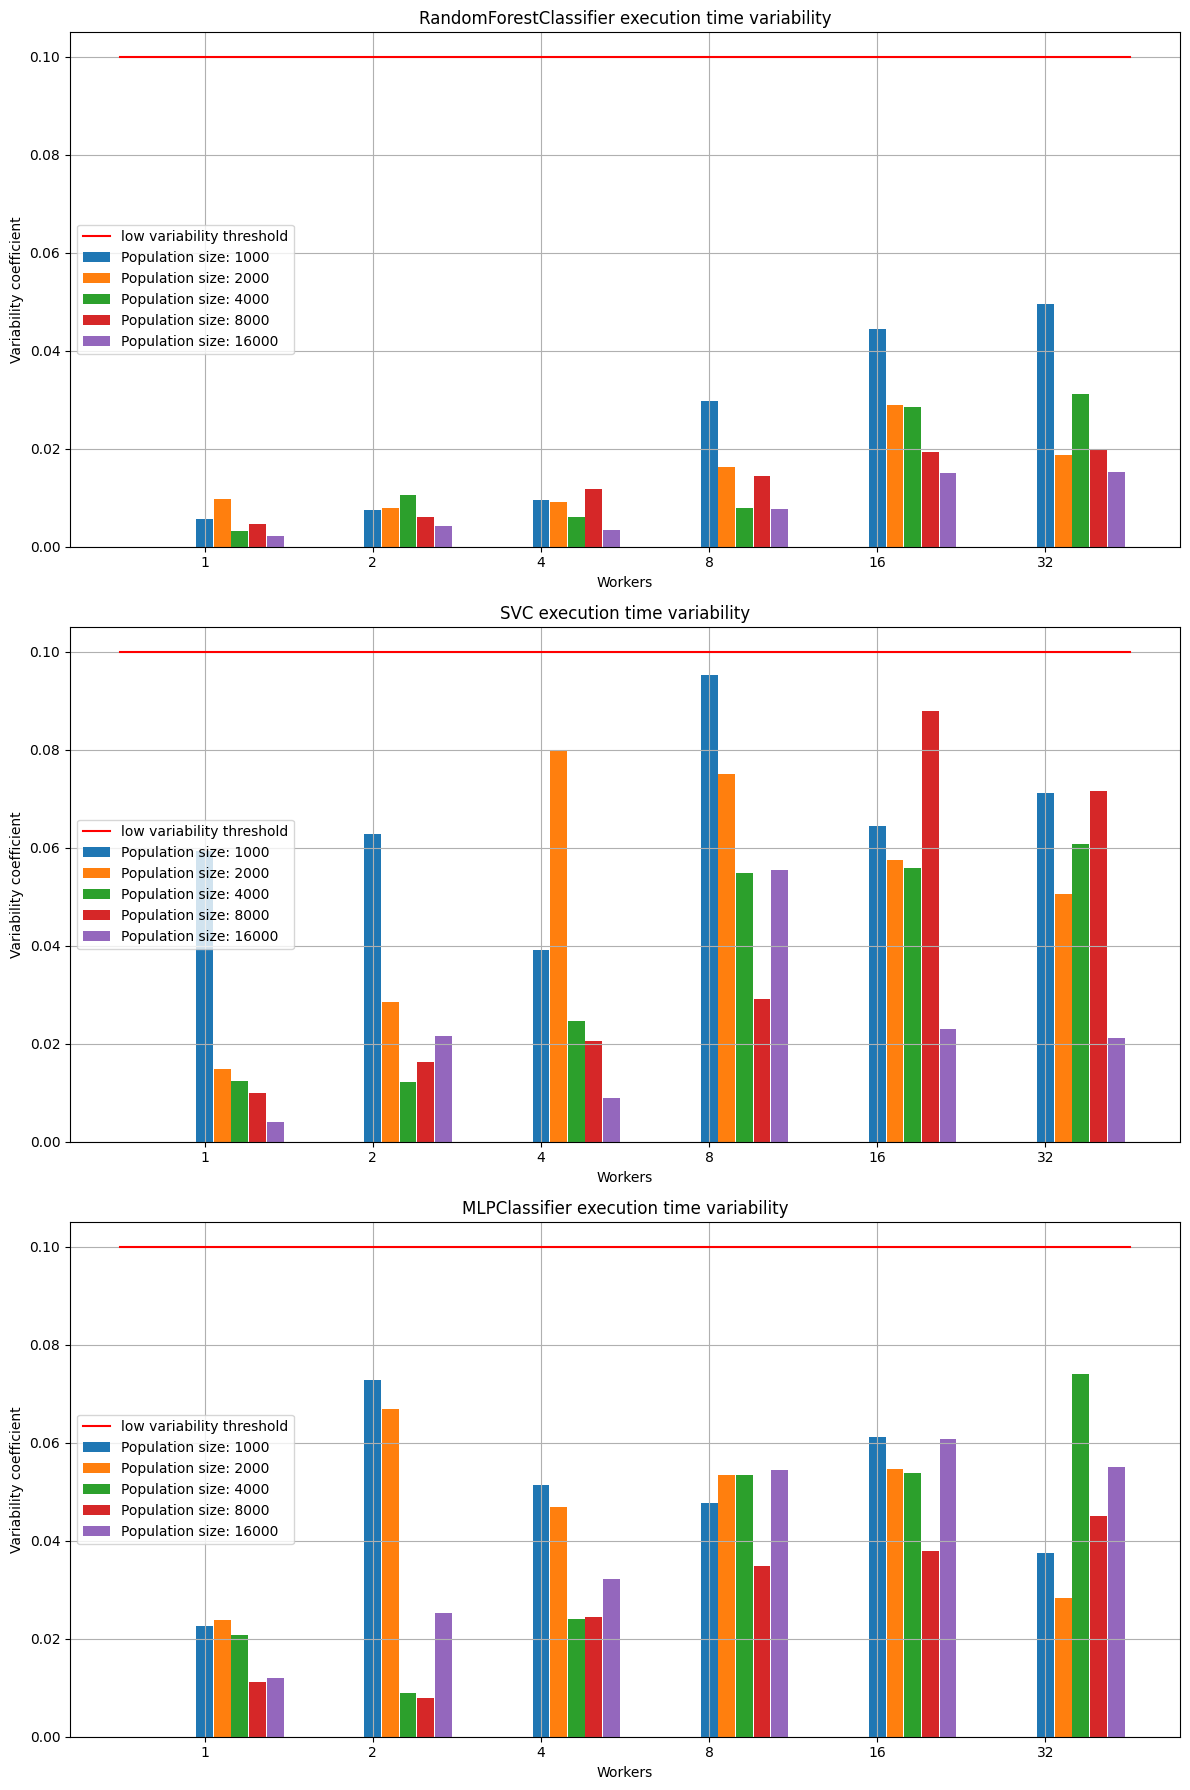

In [39]:
def plot_var_coeff(df: pd.DataFrame):
    models = df["classifier"].unique()
    workers = np.log2(np.array(df["workers"].unique()))
    population_sizes = df["population_size"].unique()

    fig, axes = plt.subplots(3, 1, figsize=(12, 18))

    for model, ax in zip(models, axes):
        ax.plot([-0.5, 5.5], [0.1, 0.1], c="r", label="low variability threshold")
        for i, ps in enumerate(population_sizes):
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            ax.set_title(f"{model} execution time variability")
            ax.set_xlabel("Workers")
            ax.set_ylabel("Variability coefficient")
            ax.bar(
                workers + i * 0.105,
                df[mask]["var_coeff"].values,
                width=0.1,
                label=f"Population size: {ps}",
            )

            ax.set_xticks(workers, labels=[int(2**w) for w in workers])
            ax.grid()
            ax.legend()

    plt.tight_layout()
    plt.show()


plot_var_coeff(ppga_df)

Dai test effettuati sembra che al variare del numero di worker e della
dimensione della popolazione il coefficiente di variabilità sia sempre sotto
il 10%.

# Analisi DEAP con multiprocessing

Il modulo DEAP offre due metodi per parallelizzare l'algoritmo genetico, il
primo tramite il modulo `multiprocessing` e il secondo tramite `scoop`. Di
seguito un'analisi della versione con `multiprocessing`. Le analisi sono
perfettamente analoghe alle precedenti.


In [40]:
# rf = pd.read_csv("../results/deap_benchmark_RandomForestClassifier_32.csv")
# svm = pd.read_csv("../results/deap_benchmark_SVC_32.csv")
# mlp = pd.read_csv("../results/deap_benchmark_MLPClassifier_32.csv")
# deap_df = pd.concat([rf, svm, mlp], axis=0)
deap_df = pd.read_csv("../results/deap_mp_32.csv")
deap_df

,classifier,population_size,workers,time,time_std
0,RandomForestClassifier,1000,1,21.155264,0.100687
1,RandomForestClassifier,1000,2,10.835100,0.096933
2,RandomForestClassifier,1000,4,5.689401,0.050888
3,RandomForestClassifier,1000,8,3.346998,0.050679
4,RandomForestClassifier,1000,16,2.059118,0.171642
...,...,...,...,...,...
85,MLPClassifier,16000,2,8.127583,0.046898
86,MLPClassifier,16000,4,6.275479,0.059855
87,MLPClassifier,16000,8,5.808897,0.053262
88,MLPClassifier,16000,16,5.724965,0.101906


## Tempo d'esecuzione

Come prima, alcuni plot rappresentati dell'andamento del tempo d'esecuzione in
funzione del diverso numero di worker e su diverse dimensioni dell'input.


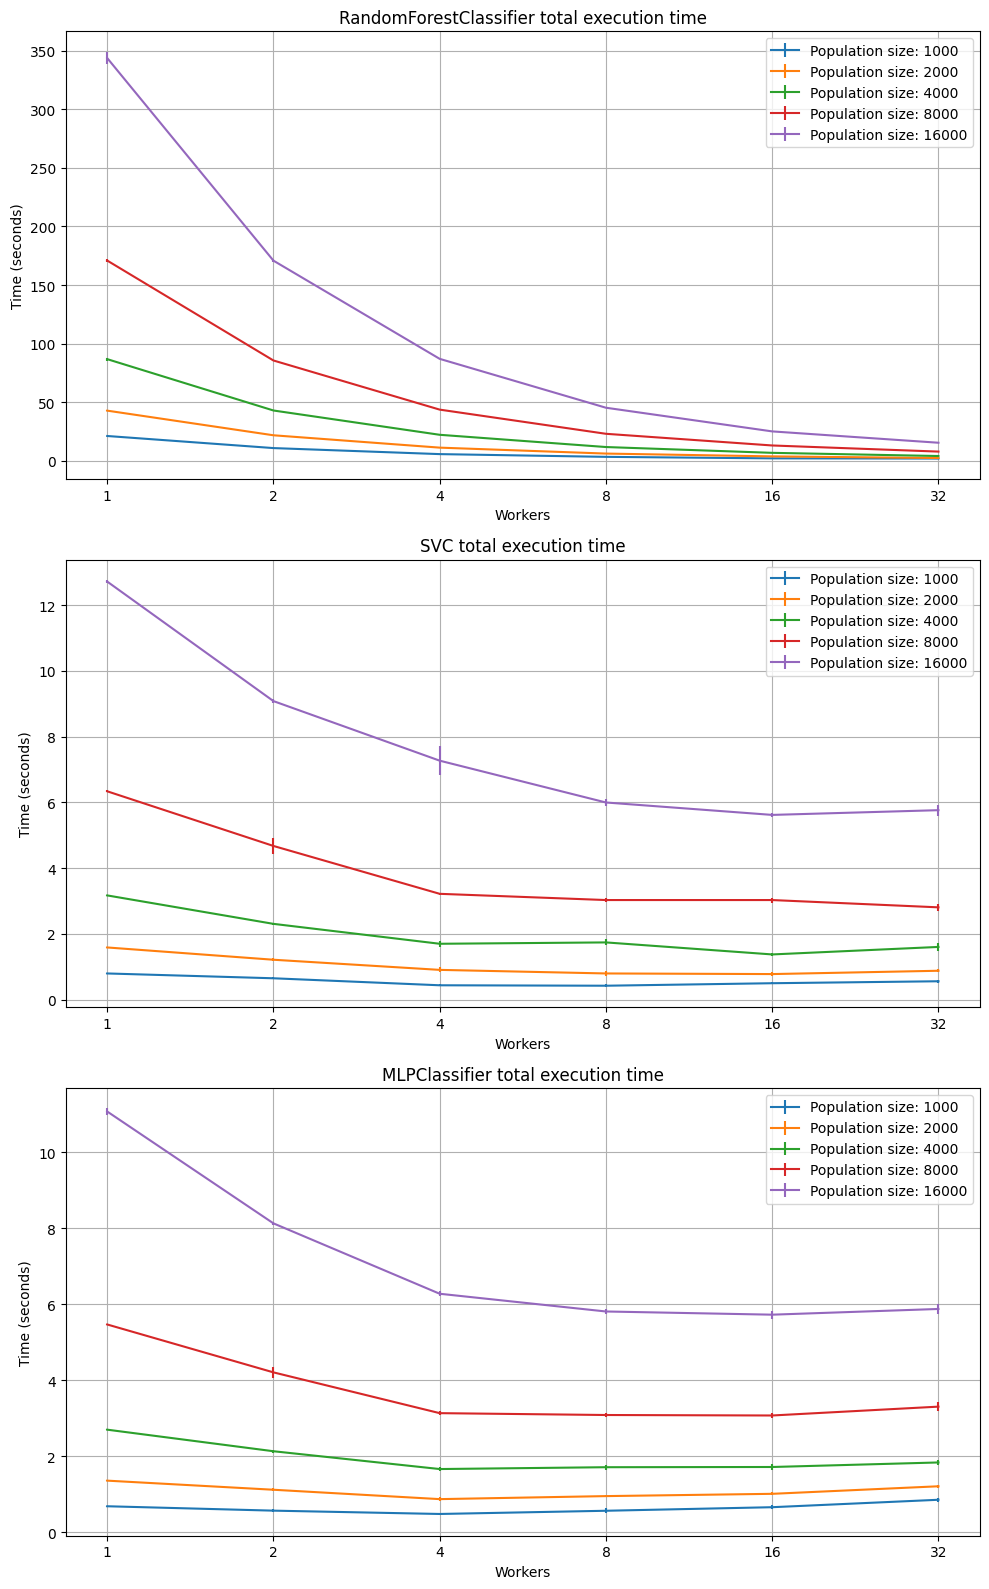

In [41]:
models = deap_df["classifier"].unique()
workers = deap_df["workers"].unique()
population_sizes = deap_df["population_size"].unique()

fig, axes = plt.subplots(3, 1, figsize=(10, 16))

for i, model in enumerate(models):
    for ps in population_sizes:
        mask = (deap_df["classifier"] == model) & (deap_df["population_size"] == ps)
        axes[i].set_title(f"{model} total execution time")
        axes[i].set_xlabel("Workers")
        axes[i].set_ylabel("Time (seconds)")
        axes[i].errorbar(
            workers,
            deap_df[mask]["time"].values,
            deap_df[mask]["time_std"],
            label=f"Population size: {ps}",
        )

        axes[i].set_xscale("log", base=2)
        axes[i].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
        axes[i].grid()
        axes[i].legend()


plt.tight_layout()
plt.show()


## Speed up

Come prima andiamo ad analizzare lo speed up ottenuto.


In [42]:
reference_times = deap_df[deap_df["workers"] == 1].set_index(
    ["classifier", "population_size"]
)["time"]

deap_df["speed_up"] = deap_df.apply(
    lambda row: reference_times.loc[(row["classifier"], row["population_size"])]
    / row["time"],
    axis=1,
)

deap_df

,classifier,population_size,workers,time,time_std,speed_up
0,RandomForestClassifier,1000,1,21.155264,0.100687,1.000000
1,RandomForestClassifier,1000,2,10.835100,0.096933,1.952475
2,RandomForestClassifier,1000,4,5.689401,0.050888,3.718364
3,RandomForestClassifier,1000,8,3.346998,0.050679,6.320668
4,RandomForestClassifier,1000,16,2.059118,0.171642,10.273944
...,...,...,...,...,...,...
85,MLPClassifier,16000,2,8.127583,0.046898,1.362147
86,MLPClassifier,16000,4,6.275479,0.059855,1.764162
87,MLPClassifier,16000,8,5.808897,0.053262,1.905863
88,MLPClassifier,16000,16,5.724965,0.101906,1.933805


Notiamo, sia dalla tabella che dal grafico di seguito, che lo speed up tramite
il modulo multiprocessing è generalmente migliore rispetto all'altro algoritmo.
Questo probabilmente dovuto a tecniche di bilanciamento del carico e di
comunicazione più avanzate. Il confronto vero e proprio sarà fatto di seguito.


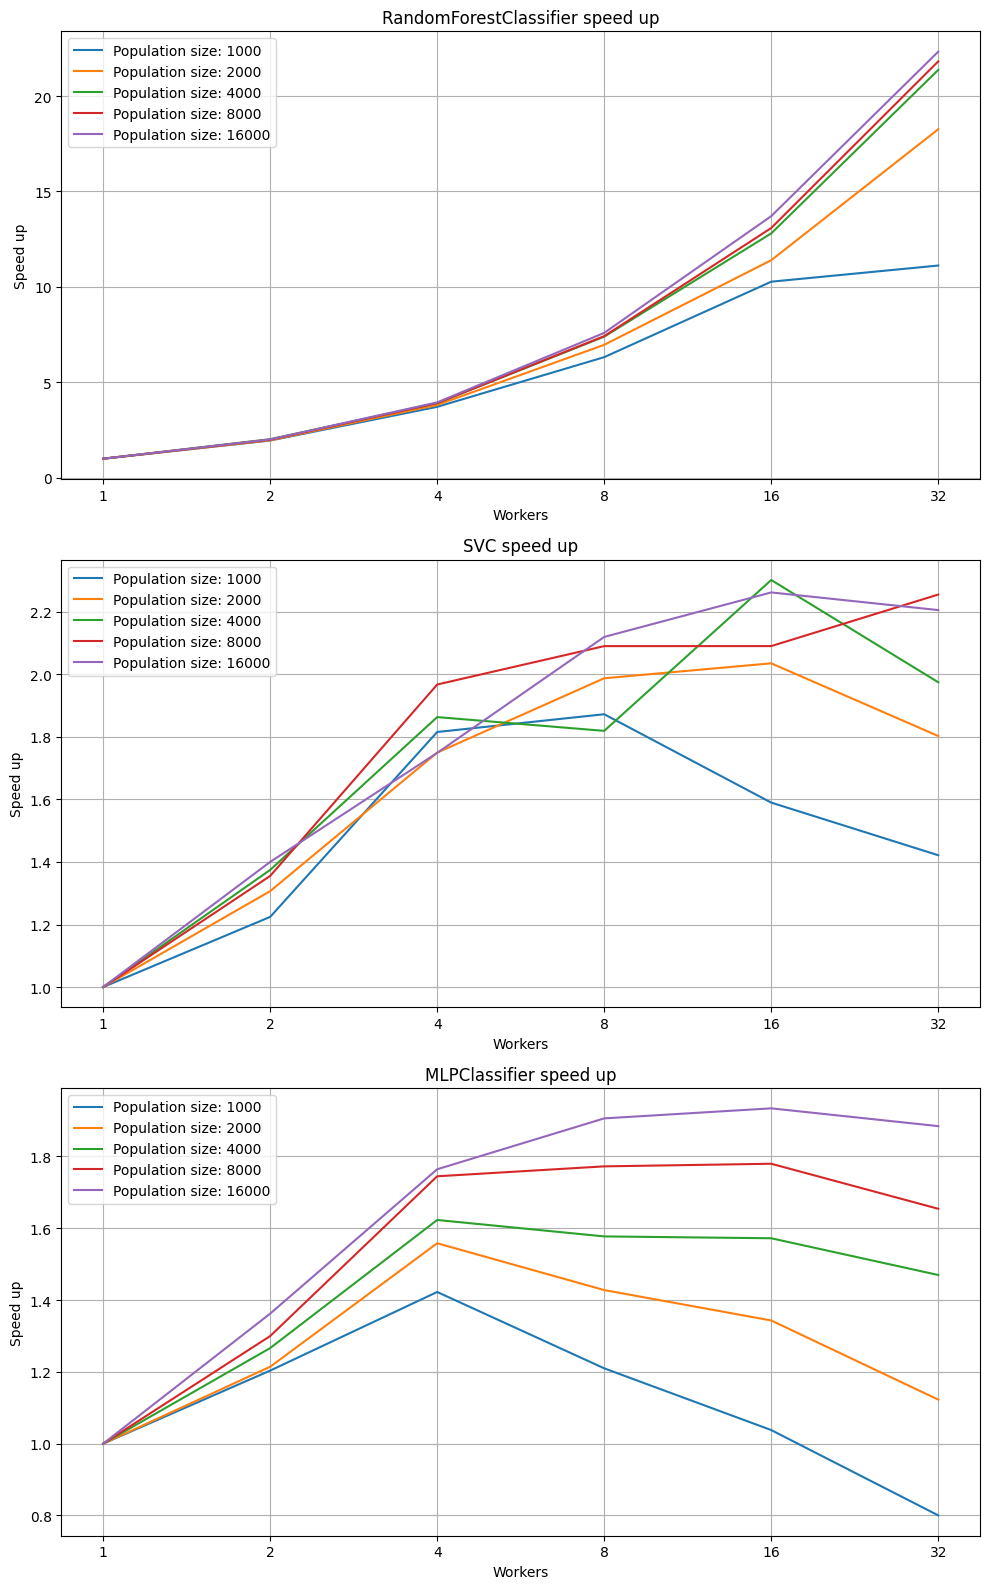

In [43]:
models = deap_df["classifier"].unique()
workers = deap_df["workers"].unique()
population_sizes = deap_df["population_size"].unique()

fig, axes = plt.subplots(3, 1, figsize=(10, 16))

for i, model in enumerate(models):
    for ps in population_sizes:
        mask = (deap_df["classifier"] == model) & (deap_df["population_size"] == ps)
        axes[i].set_title(f"{model} speed up")
        axes[i].set_xlabel("Workers")
        axes[i].set_ylabel("Speed up")
        axes[i].plot(
            workers,
            deap_df[mask]["speed_up"].values,
            label=f"Population size: {ps}",
        )

        axes[i].set_xscale("log", base=2)
        axes[i].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
        axes[i].grid()
        axes[i].legend()


plt.tight_layout()
plt.show()


## Stabilità

Come in precedenza andiamo a calcolare il coefficiente di variabilità
dell'algoritmo.


In [44]:
deap_df["var_coeff"] = deap_df["time_std"] / deap_df["time"]
deap_df

,classifier,population_size,workers,time,time_std,speed_up,var_coeff
0,RandomForestClassifier,1000,1,21.155264,0.100687,1.000000,0.004759
1,RandomForestClassifier,1000,2,10.835100,0.096933,1.952475,0.008946
2,RandomForestClassifier,1000,4,5.689401,0.050888,3.718364,0.008944
3,RandomForestClassifier,1000,8,3.346998,0.050679,6.320668,0.015142
4,RandomForestClassifier,1000,16,2.059118,0.171642,10.273944,0.083357
...,...,...,...,...,...,...,...
85,MLPClassifier,16000,2,8.127583,0.046898,1.362147,0.005770
86,MLPClassifier,16000,4,6.275479,0.059855,1.764162,0.009538
87,MLPClassifier,16000,8,5.808897,0.053262,1.905863,0.009169
88,MLPClassifier,16000,16,5.724965,0.101906,1.933805,0.017800


A differenza del caso precedente è possibile, anche solo visivamente, notare
una maggiore variabilità nei tempi di esecuzione, soprattutto nel caso della
SVM e del MultiLayer Perceptron.


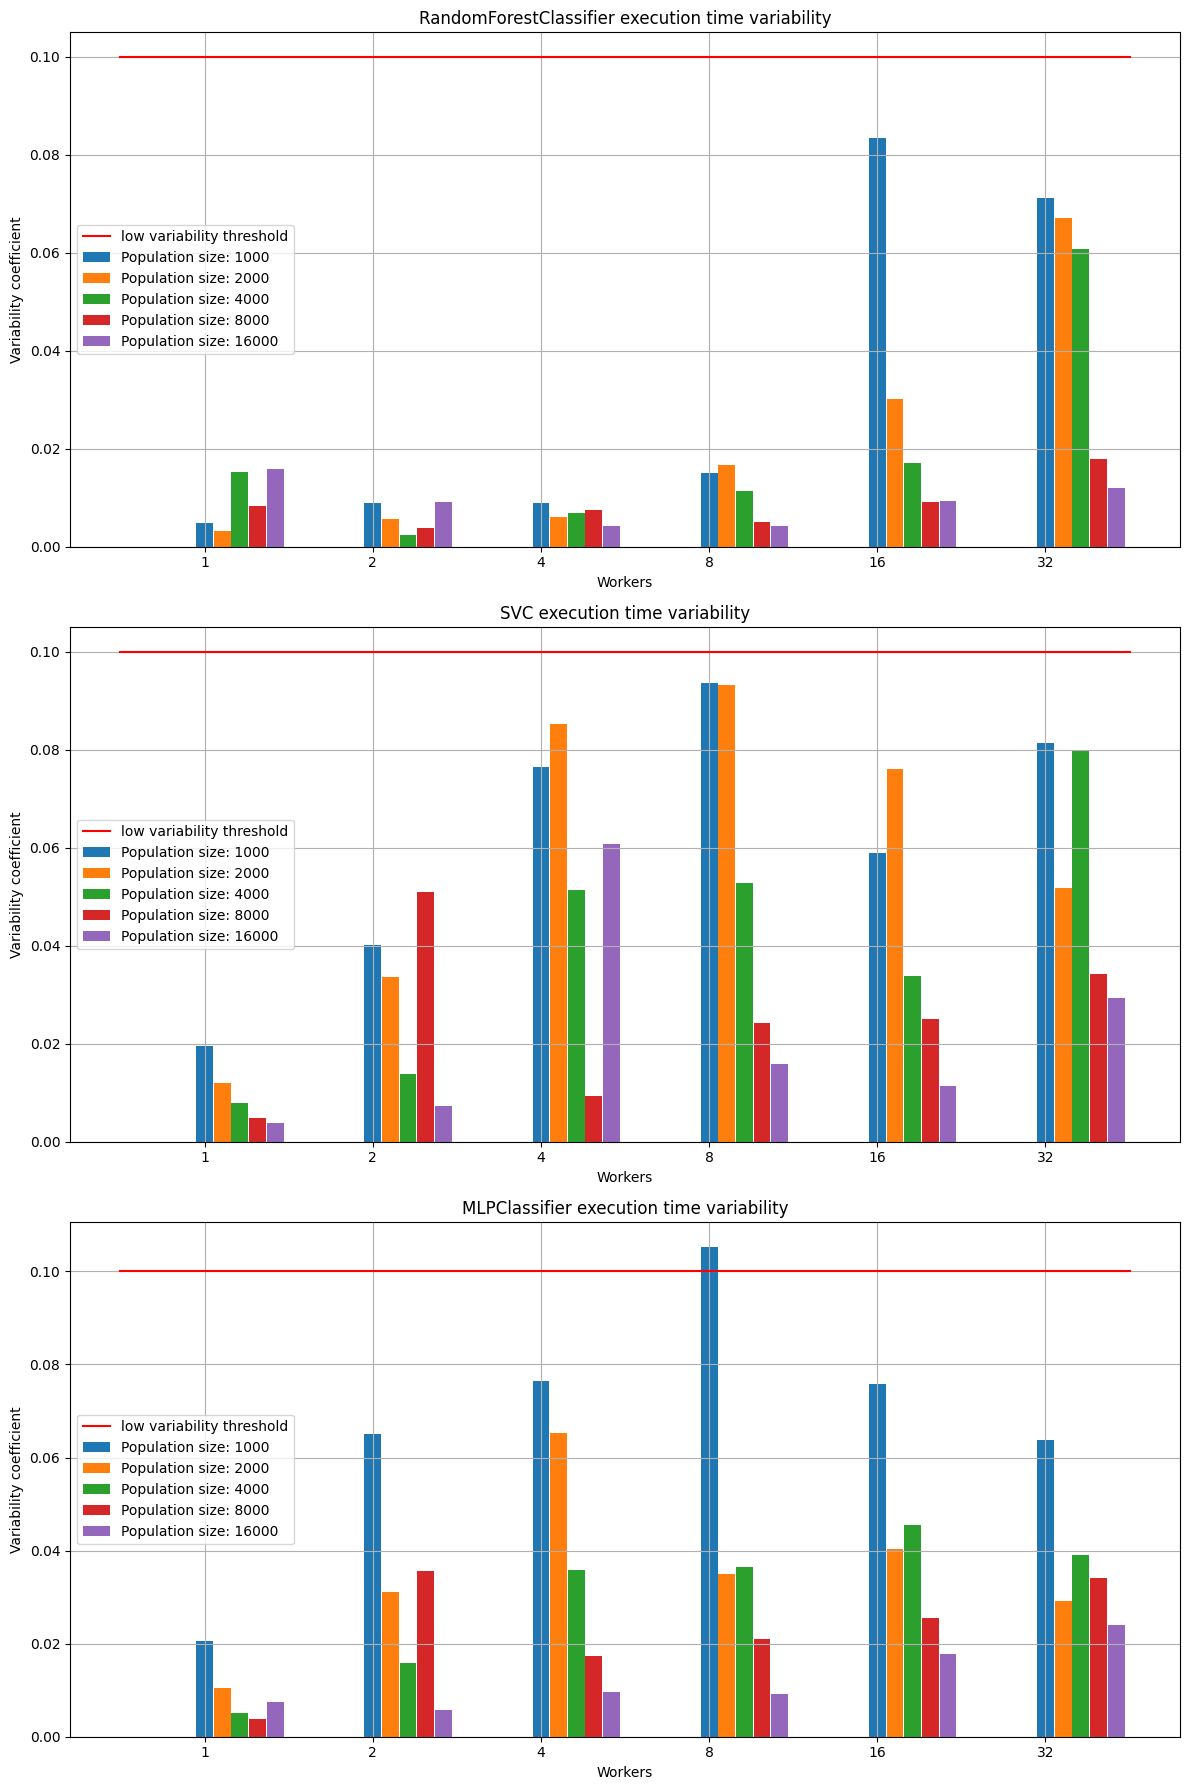

In [45]:
plot_var_coeff(deap_df)

# Confronto con DEAP

Passiamo a confrontare le prestazioni con la libreria DEAP. Procederemo
confrontando tre parametri:

- Tempo d'esecuzione
- Speed up
- Coefficiente di speed up

L'ultimo è un parametro che ci permette di paragonare lo speed up in modo
proporzionale tra i due algoritmi che possono aver ottenuto tempi d'esecuzione
differenti.

## Tempo d'esecuzione

Il primo confronto è semplicemente sul tempo d'esecuzione puro dei due
algoritmi:


In [46]:
time_cmp = pd.DataFrame(
    {
        "classifier": ppga_df["classifier"].values,
        "population_size": ppga_df["population_size"].values,
        "workers": ppga_df["workers"].values,
        "ppga": ppga_df["time"].values,
        "deap": deap_df["time"].values,
    }
)

time_cmp

,classifier,population_size,workers,ppga,deap
0,RandomForestClassifier,1000,1,16.071994,21.155264
1,RandomForestClassifier,1000,2,8.558658,10.835100
2,RandomForestClassifier,1000,4,4.458123,5.689401
3,RandomForestClassifier,1000,8,2.578786,3.346998
4,RandomForestClassifier,1000,16,1.905234,2.059118
...,...,...,...,...,...
85,MLPClassifier,16000,2,6.343140,8.127583
86,MLPClassifier,16000,4,4.065129,6.275479
87,MLPClassifier,16000,8,3.068803,5.808897
88,MLPClassifier,16000,16,2.818851,5.724965


Come possiamo vedere dai grafici di seguito sembra che DEAP sia leggermente
più lento.


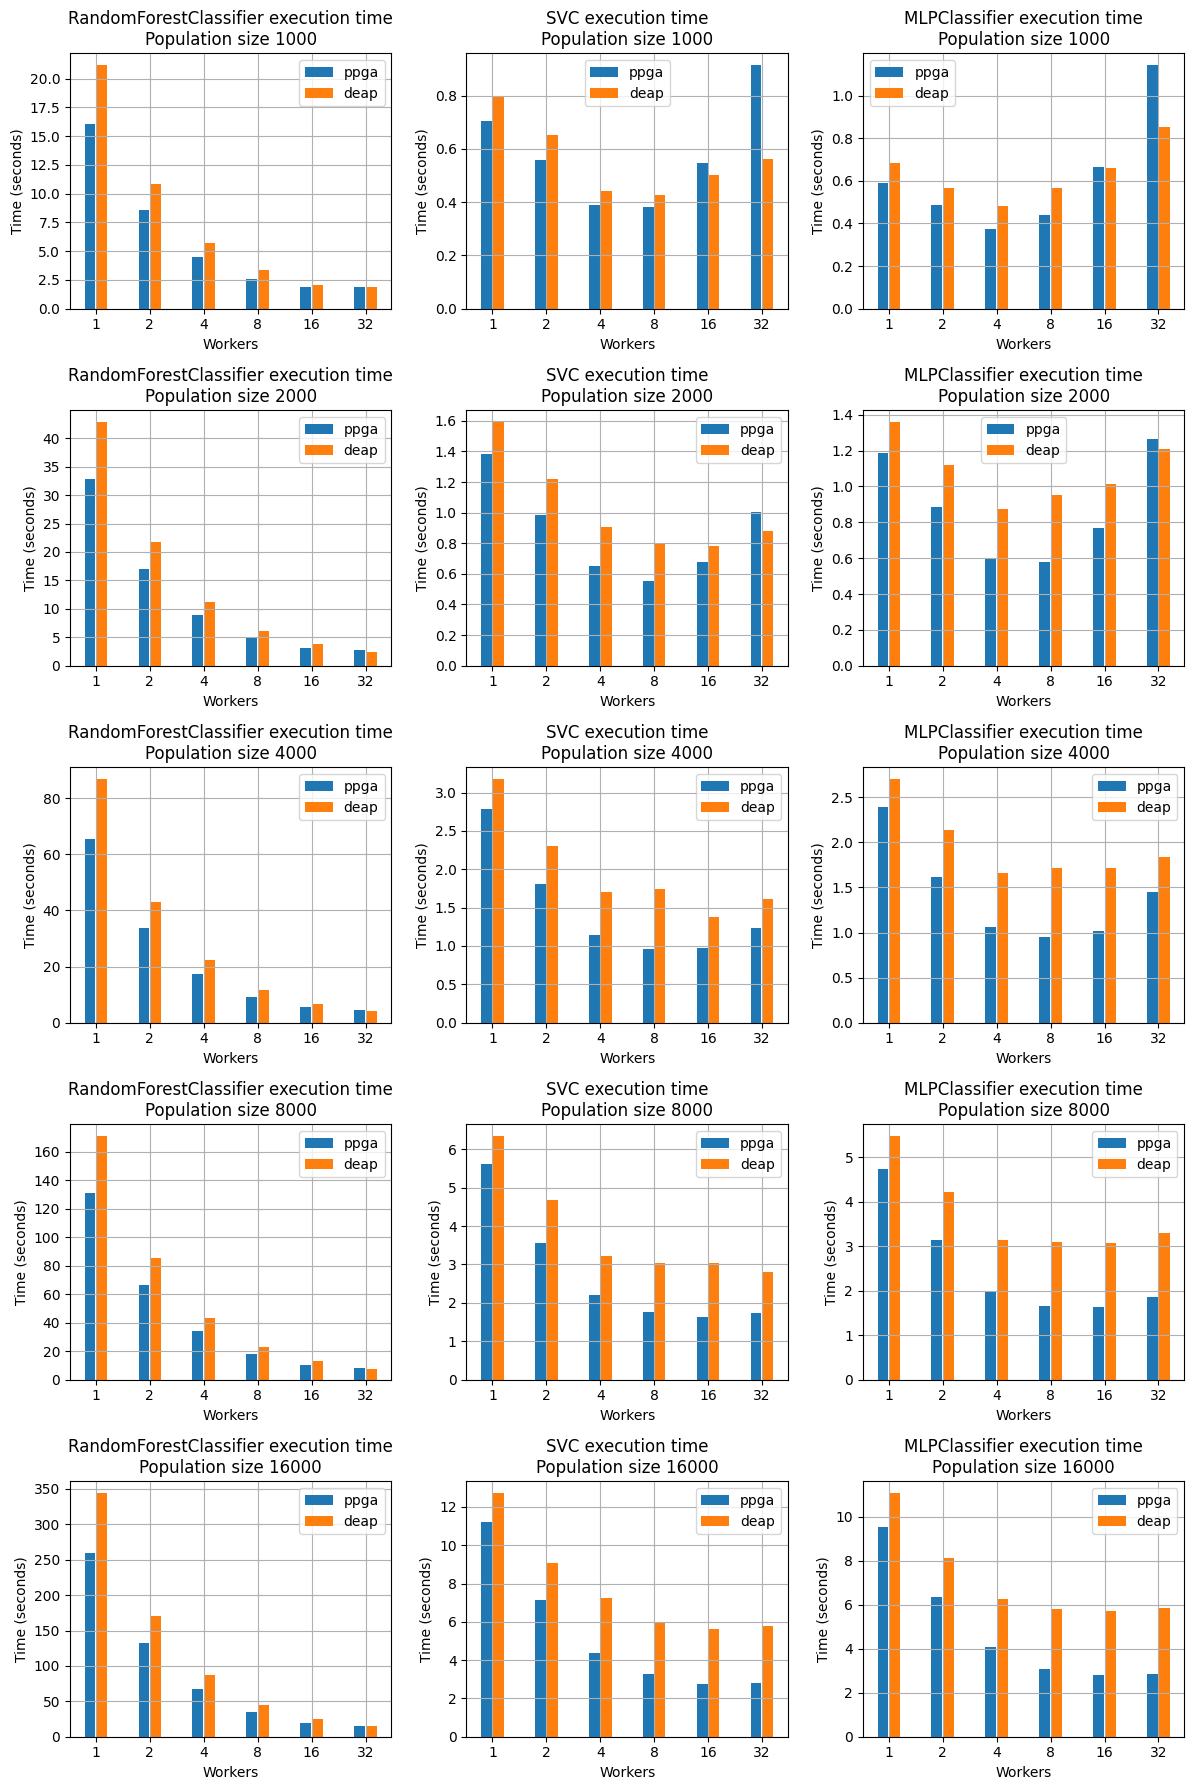

In [47]:
def plot_time_diff(df):
    models = df["classifier"].unique()
    workers = np.log2(df["workers"].unique())
    population_sizes = df["population_size"].unique()

    fig, axes = plt.subplots(len(population_sizes), len(models), figsize=(12, 18))

    for i, ps in enumerate(population_sizes):
        for j, model in enumerate(models):
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            axes[i][j].set_title(f"{model} execution time\nPopulation size {ps}")
            axes[i][j].set_xlabel("Workers")
            axes[i][j].set_ylabel("Time (seconds)")
            axes[i][j].bar(
                workers - 0.11, df[mask]["ppga"].values, width=0.2, label="ppga"
            )
            axes[i][j].bar(
                workers + 0.11, df[mask]["deap"].values, width=0.2, label="deap"
            )

            axes[i][j].set_xticks(workers, labels=[int(2**i) for i in workers])
            axes[i][j].legend()
            axes[i][j].grid()

    plt.tight_layout()
    plt.show()


plot_time_diff(time_cmp)

Di seguito un confronto tra il numero di volte in cui `ppga` ha offerto
performance migliori rispetto a DEAP.


In [48]:
ppga_better_time = time_cmp[time_cmp["ppga"] < time_cmp["deap"]]
print(
    f"ppga better than deap {len(ppga_better_time) / len(time_cmp) * 100.0:.2f}% of the times"
)

ppga better than deap 90.00% of the times


Andiamo a vedere i valori minimi, medi e massimi dell'aumento di performance.


In [49]:
improvement = (
    (ppga_better_time["deap"] - ppga_better_time["ppga"])
    / ppga_better_time["deap"]
    * 100.0
)
print(f"min improvement: {improvement.min():.2f}%")
print(f"mean improvement: {improvement.mean():.2f}%")
print(f"max improvement: {improvement.max():.2f}%")

min improvement: 0.50%
mean improvement: 25.69%
max improvement: 51.66%


Come vediamo `ppga` è tendenzialmente più veloce, mediamente del 20%.

Ripetiamo la stessa analisi ma considerando solo i casi in cui DEAP ha fornito
le performance migliori.


In [50]:
deap_better_time = time_cmp[time_cmp["deap"] < time_cmp["ppga"]]
print(
    f"deap better than ppga {len(deap_better_time) / len(time_cmp) * 100.0:.2f}% of the times"
)

improvement = (
    (deap_better_time["ppga"] - deap_better_time["deap"])
    / deap_better_time["ppga"]
    * 100.0
)
print(f"min improvement: {improvement.min():.2f}%")
print(f"mean improvement: {improvement.mean():.2f}%")
print(f"max improvement: {improvement.max():.2f}%")

deap better than ppga 10.00% of the times
min improvement: 1.17%
mean improvement: 13.84%
max improvement: 38.42%


Non sembrano esserci grandi differenze per quanto riguarda i valori minimi e
medi, ma è stato registrato almeno un caso in cui DEAP ha fornito performance
migliori del 50% rispetto a PPGA.

## Speed up

Passiamo ora al confronto dello speed up tra i due algoritmi. Le analisi saranno
analoghe a quelle fatte per il tempo d'esecuzione.


In [51]:
speedup_cmp = pd.DataFrame(
    {
        "classifier": ppga_df["classifier"].values,
        "population_size": ppga_df["population_size"].values,
        "workers": ppga_df["workers"].values,
        "ppga": ppga_df["speed_up"].values,
        "deap": deap_df["speed_up"].values,
    }
)

speedup_cmp = speedup_cmp[speedup_cmp["workers"] != 1]
speedup_cmp

,classifier,population_size,workers,ppga,deap
1,RandomForestClassifier,1000,2,1.877864,1.952475
2,RandomForestClassifier,1000,4,3.605104,3.718364
3,RandomForestClassifier,1000,8,6.232387,6.320668
4,RandomForestClassifier,1000,16,8.435708,10.273944
5,RandomForestClassifier,1000,32,8.491556,11.121101
...,...,...,...,...,...
85,MLPClassifier,16000,2,1.506793,1.362147
86,MLPClassifier,16000,4,2.351167,1.764162
87,MLPClassifier,16000,8,3.114503,1.905863
88,MLPClassifier,16000,16,3.390671,1.933805


Stavolta sembra che DEAP abbia valori di speed up migliori, come si può notare
dai grafici riportati di seguito.


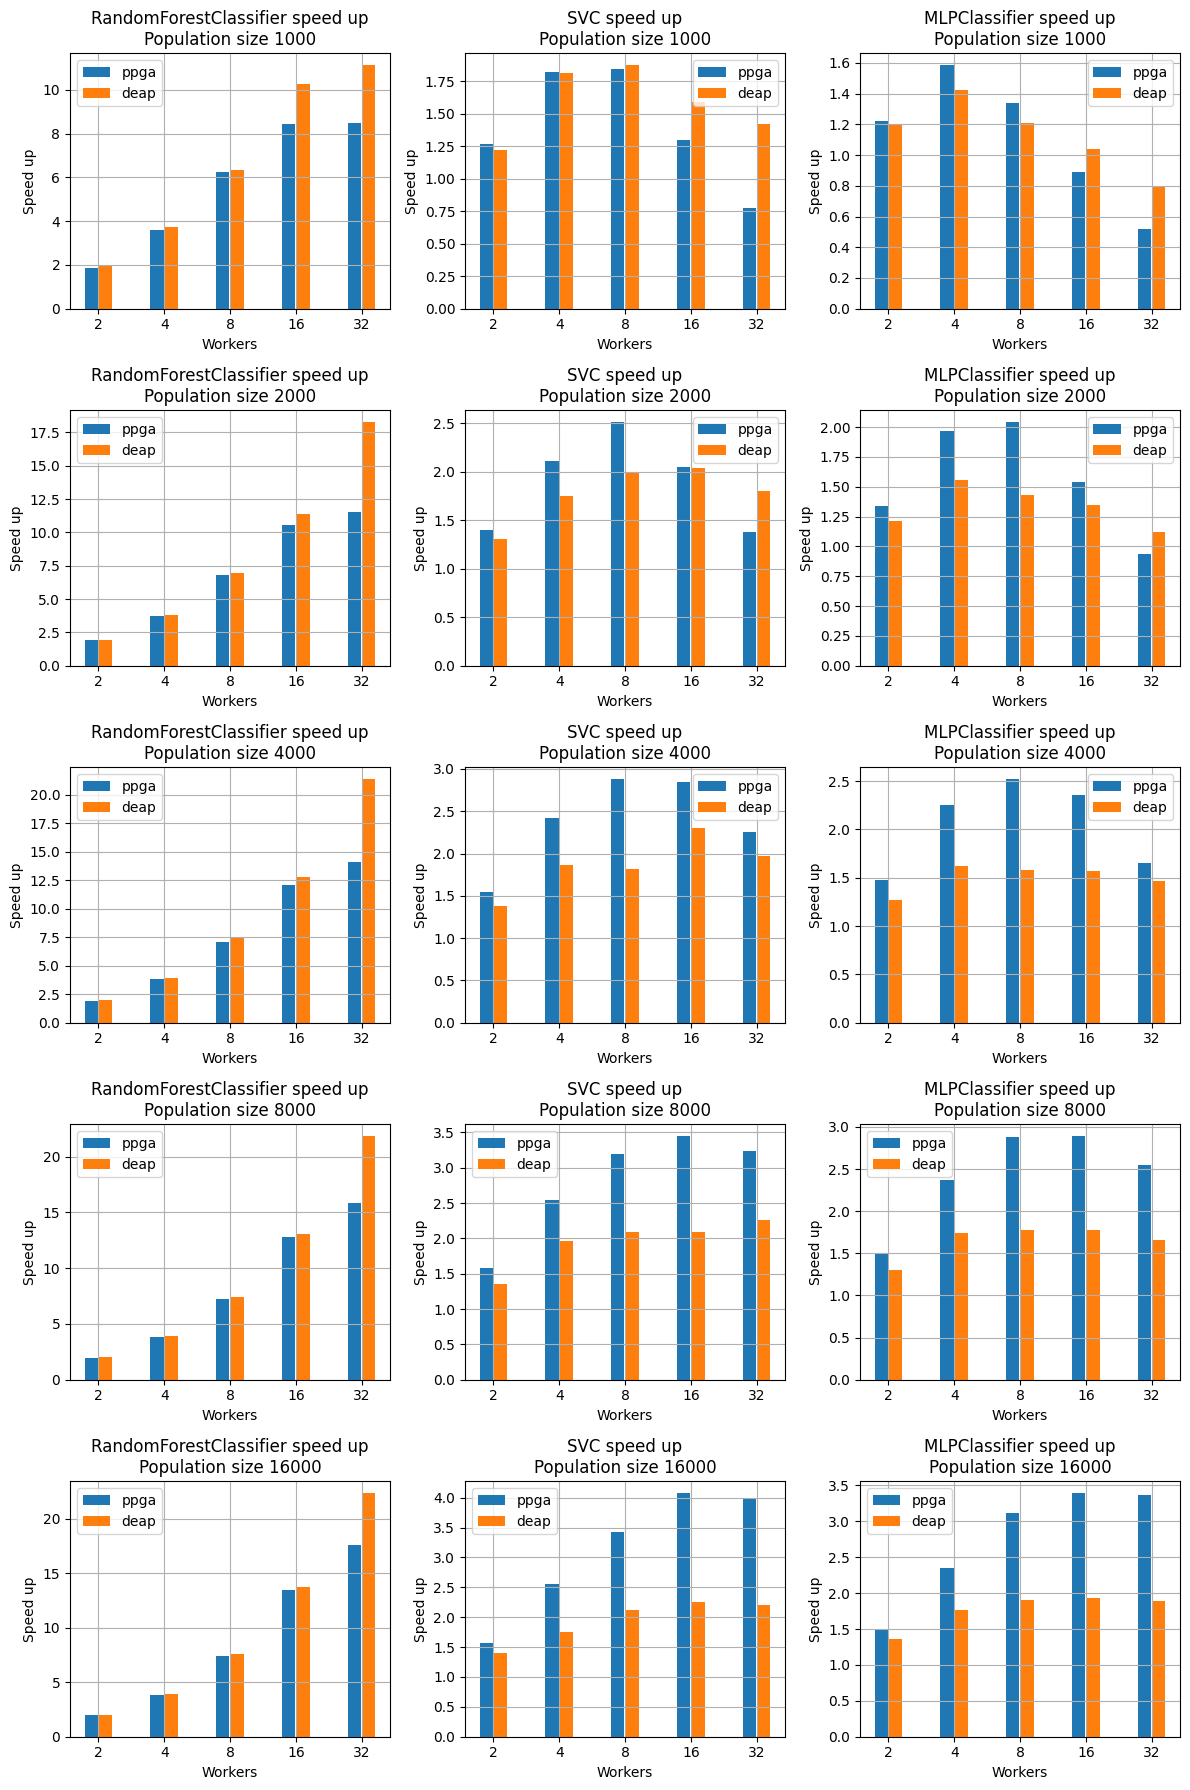

In [52]:
def plot_time_diff(df):
    models = df["classifier"].unique()
    workers = np.log2(df["workers"].unique())
    population_sizes = df["population_size"].unique()

    fig, axes = plt.subplots(len(population_sizes), len(models), figsize=(12, 18))

    for i, ps in enumerate(population_sizes):
        for j, model in enumerate(models):
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            axes[i][j].set_title(f"{model} speed up\nPopulation size {ps}")
            axes[i][j].set_xlabel("Workers")
            axes[i][j].set_ylabel("Speed up")
            axes[i][j].bar(
                workers - 0.11, df[mask]["ppga"].values, width=0.2, label="ppga"
            )
            axes[i][j].bar(
                workers + 0.11, df[mask]["deap"].values, width=0.2, label="deap"
            )

            axes[i][j].set_xticks(workers, labels=[int(2**i) for i in workers])
            axes[i][j].legend()
            axes[i][j].grid()

    plt.tight_layout()
    plt.show()


plot_time_diff(speedup_cmp)

Andiamo però a vedere quante volte DEAP è stato migliore di PPGA come abbiamo
fatto in precedenza.


In [53]:
ppga_better_speedup = speedup_cmp[speedup_cmp["ppga"] > speedup_cmp["deap"]]
print(
    f"ppga better than deap {len(ppga_better_speedup) / len(speedup_cmp) * 100.0:.2f}% of the times"
)

improvement = (
    (ppga_better_speedup["ppga"] - ppga_better_speedup["deap"])
    / ppga_better_speedup["deap"]
    * 100.0
)
print(f"min improvement: {improvement.min():.2f}%")
print(f"mean improvement: {improvement.mean():.2f}%")
print(f"max improvement: {improvement.max():.2f}%")

ppga better than deap 57.33% of the times
min improvement: 0.30%
mean improvement: 34.20%
max improvement: 81.18%


In [54]:
deap_better_speedup = speedup_cmp[speedup_cmp["deap"] > speedup_cmp["ppga"]]
print(
    f"deap better than ppga {len(deap_better_speedup) / len(speedup_cmp) * 100.0:.2f}% of the times"
)

improvement = (
    (deap_better_speedup["deap"] - deap_better_speedup["ppga"])
    / deap_better_speedup["ppga"]
    * 100.0
)
print(f"min improvement: {improvement.min():.2f}%")
print(f"mean improvement: {improvement.mean():.2f}%")
print(f"max improvement: {improvement.max():.2f}%")

deap better than ppga 42.67% of the times
min improvement: 1.39%
mean improvement: 16.14%
max improvement: 83.94%


In questo caso DEAP risulta avere i migliori valori di speed la maggior parte
delle volte.

## Coefficiente di speed up

Confrontare il tempo d'esecuzione può essere un buon indice per paragonare le
performance di un algoritmo, quando però andiamo a paragonare i valori di speed
up non otteniamo una vera e propria misura di quanto un modello di calcolo
parallelo sia migliore rispetto ad un altro. Questo è anche dovuto al fatto
che il tempo d'esecuzione, a parità di worker impiegati, potrebbe variare.
Diventa quindi necessario ricavare una misura che sia proporzionale al tempo
d'esecuzione. Di seguito viene calcolato un "coefficiente di speed up"

$$\frac{s}{t}$$

dove $s$ è lo speed up ottenuto e $t$ il tempo totale d'esecuzione.


In [55]:
speedup_coeff_cmp = pd.DataFrame(
    {
        "classifier": ppga_df["classifier"].values,
        "population_size": ppga_df["population_size"].values,
        "workers": ppga_df["workers"].values,
        "ppga": (ppga_df["speed_up"] / ppga_df["time"]).values,
        "deap": (deap_df["speed_up"] / deap_df["time"]).values,
    }
)

speedup_coeff_cmp = speedup_coeff_cmp[speedup_coeff_cmp["workers"] != 1]
speedup_coeff_cmp

,classifier,population_size,workers,ppga,deap
1,RandomForestClassifier,1000,2,0.219411,0.180199
2,RandomForestClassifier,1000,4,0.808660,0.653560
3,RandomForestClassifier,1000,8,2.416791,1.888459
4,RandomForestClassifier,1000,16,4.427650,4.989487
5,RandomForestClassifier,1000,32,4.486471,5.846247
...,...,...,...,...,...
85,MLPClassifier,16000,2,0.237547,0.167596
86,MLPClassifier,16000,4,0.578374,0.281120
87,MLPClassifier,16000,8,1.014892,0.328094
88,MLPClassifier,16000,16,1.202856,0.337785


Dalla tabella e dai grafici riportati di seguito possiamo notare come PPGA
offra, nella maggior parte dei casi, un coefficiente migliore.

Dobbiamo però considerare anche l'andamento di tale coefficiente caso per caso.
Se rimane stabile o tende a crescere con il crescere del numero di worker,
potrebbe essere un buon indice per valutare la scalabilità dell'algoritmo
su un numero ancora più alto di worker.


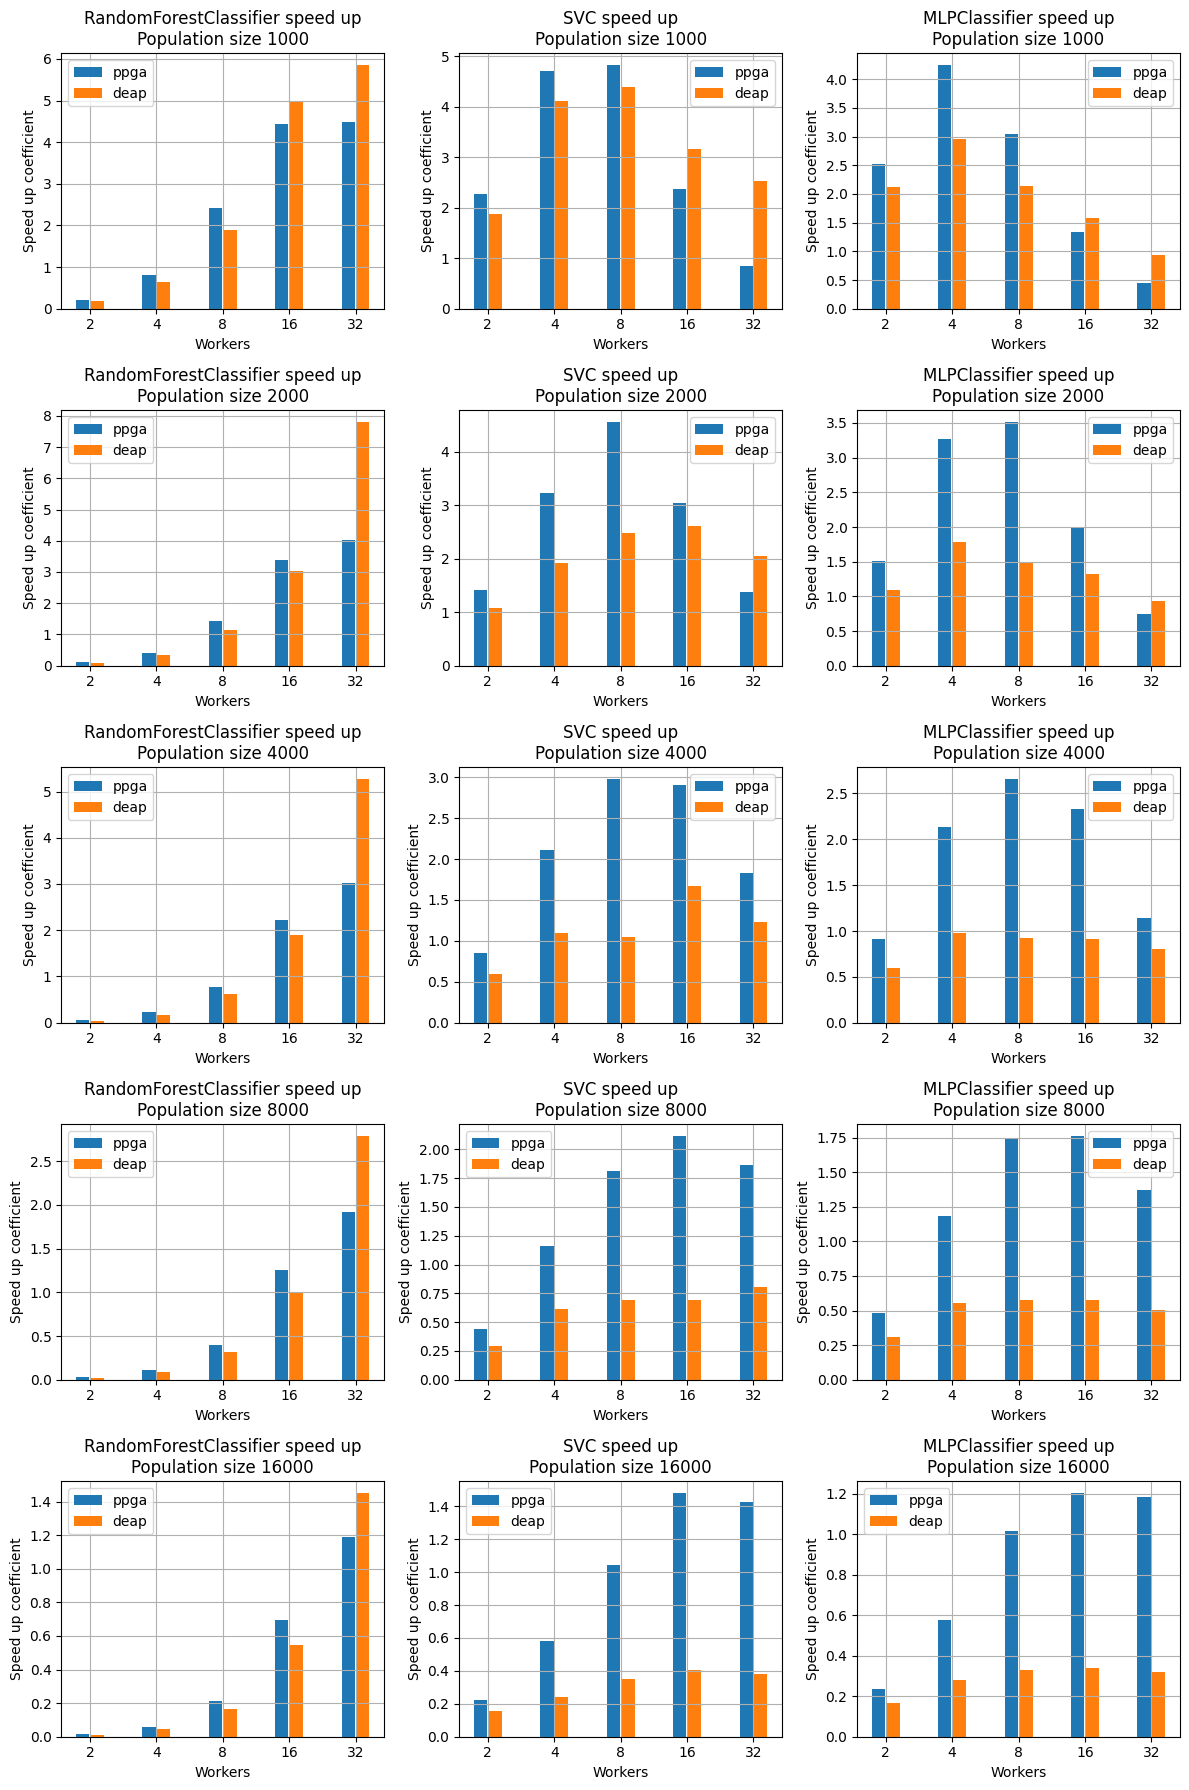

In [56]:
def plot_time_diff(df):
    models = df["classifier"].unique()
    workers = np.log2(df["workers"].unique())
    population_sizes = df["population_size"].unique()

    fig, axes = plt.subplots(len(population_sizes), len(models), figsize=(12, 18))

    for i, ps in enumerate(population_sizes):
        for j, model in enumerate(models):
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            axes[i][j].set_title(f"{model} speed up\nPopulation size {ps}")
            axes[i][j].set_xlabel("Workers")
            axes[i][j].set_ylabel("Speed up coefficient")
            axes[i][j].bar(
                workers - 0.11, df[mask]["ppga"].values, width=0.2, label="ppga"
            )
            axes[i][j].bar(
                workers + 0.11, df[mask]["deap"].values, width=0.2, label="deap"
            )

            axes[i][j].set_xticks(workers, labels=[int(2**i) for i in workers])
            axes[i][j].legend()
            axes[i][j].grid()

    plt.tight_layout()
    plt.show()


plot_time_diff(speedup_coeff_cmp)

Come già detto, il coefficiente vuole essere un indice di quanto l'algoritmo
scala bene con il crescere del numero di worker. Come possiamo vedere, una
casistica in cui il carico dei singoli worker tende ad essere leggero, un
approccio in cui c'è un bilanciamento automatico e dinamico del carico di lavoro
risulta essere vincente sia in termini di tempo d'esecuzione, sia in termini di
utilizzo delle risorse fornite (in questo caso i core multipli della macchina).

Quando però il workload si fa più intenso, sembra essere più vantaggioso
partizionare subito l'input e lasciare lavorare i worker senza ulteriori
overhead di sincronizzazione e comunicazione.


In [57]:
ppga_better_coeff = speedup_coeff_cmp[
    speedup_coeff_cmp["ppga"] > speedup_coeff_cmp["deap"]
]

print(
    f"deap better than ppga {len(ppga_better_coeff) / len(speedup_coeff_cmp) * 100.0:.2f}% of the times"
)

improvement = (
    (ppga_better_coeff["ppga"] - ppga_better_coeff["deap"])
    / ppga_better_coeff["deap"]
    * 100.0
)
print(f"min improvement: {improvement.min():.2f}%")
print(f"mean improvement: {improvement.mean():.2f}%")
print(f"max improvement: {improvement.max():.2f}%")

deap better than ppga 84.00% of the times
min improvement: 9.92%
mean improvement: 84.10%
max improvement: 272.03%


In [58]:
deap_better_coeff = speedup_coeff_cmp[
    speedup_coeff_cmp["deap"] > speedup_coeff_cmp["ppga"]
]

print(
    f"deap better than ppga {len(deap_better_coeff) / len(speedup_coeff_cmp) * 100.0:.2f}% of the times"
)

improvement = (
    (deap_better_coeff["deap"] - deap_better_coeff["ppga"])
    / deap_better_coeff["ppga"]
    * 100.0
)
print(f"min improvement: {improvement.min():.2f}%")
print(f"mean improvement: {improvement.mean():.2f}%")
print(f"max improvement: {improvement.max():.2f}%")

deap better than ppga 16.00% of the times
min improvement: 12.69%
mean improvement: 58.88%
max improvement: 198.70%


# Conclusioni

In quanto a tempo d'esecuzione sembra prevalere PPGA con un buon 80% dei test
eseguiti con un tempo inferiore a DEAP. Di questo 80% c'è un miglioramento
medio del 20% e un miglioramento massimo del 40%.

Sui valori di speed up delle versioni parallele DEAP riesce in diversi casi a
sfruttare meglio le risorse computazionali a disposizione. La differenza tende
però ad appianarsi quando il carico di lavoro di ogni worker si fa sempre più
grande.

Per l'ultimo coefficiente valgono più o meno le stesse considerazioni fatte
sullo speed up. Come si nota dai grafici, i casi in cui il coefficiente è più
alto per PPGA sono quelli con pochi worker, che dunque saranno più carichi
di lavoro. Qui diventa determinate il tempo d'esecuzione, tendenzialmente
inferiore, di PPGA.

Se però entrano in gioco un alto numero di worker e workload eterogenei, la
miglior scelta ricade sul `multiprocessing.Pool` utilizzato da DEAP.

## Considerazioni parallelismo

Prima di concludere vorrei evidenziare alcune possibili criticità quando si
lavora con la versione parallela di PPGA, prendendo sempre come riferimento il
solito problema. A differenza di DEAP, che parallelizza solo la fase di
valutazione, PPGA parallelizza anche le fasi di crossover, mutazione.

Quelle di seguito non sono considerazioni sulle performance, bensì sulla
qualità dei risultati ottenuti.

### Crossover

Dato che la genereazione della popolazione iniziale avviene per copia, la
diversità genetica iniziale è pari a zero. Per un algoritmo genetico, questo
è in generale un problema dato che sfrutta meccanismi come il crossover per
ricombinare i cromosomi tra individui diversi.

Nel nostro caso partiamo però da una situazione in cui tutti gli individui sono
cloni e utilizziamo metodi di crossover come quello a singolo o doppio punto di
crossover. Questi metodi non producono nuovi valori per le feature ma si
limitano ad esplorare i valori già esistenti.

Ne segue che l'applicazione del crossover tra due cloni risulterà nella
generazione di altri due cloni identici tra di loro e ai loro genitori.

### Mutazione

Per le prime iterazioni ci si affida quindi all'operatore di mutazione come
unico meccanismo per introdurre diversità genetica. Il problema è che la
mutazione ha generalmente una probabilità bassa di essere applicata (in genere
20/30%). Se aggiungiamo poi che ogni feature ha una probabilità indipendente di
essere modificata, la probabilità che un individuo scelto per la mutazione,
venga effettivamente modificato, cala ulteriormente.

Quando partizioniamo la popolazione tra molti worker si potrebbe andare
incontro ad un problema nel caso in cui il rapporto

$$\frac{N}{W}$$

dove $N$ è il numero di individui e $W$ è il numero di worker, è troppo basso.
Si rischia che i worker mutino pochi individui o nessuno, lasciando la
diversità genetica bassa per diverse iterazioni.

Per evitare che ciò accada c'è bisogno che la probabilità indipendente di
modificare ogni feature faccia sì che mediamente, almeno una feature venga
modificata. Per esempio ponendola a $1 / L$ dove $L$ è la lunghezza del
cromosoma.

In secondo luogo è necessario che il numero di individui inviato ad ogni worker
sia abbastanza grande da "garantire" un certo numero di individui mutati.

### Seme di casualità

Dato che le fasi di crossover e mutazione fanno leva sulla generazione di
numeri casuali, è necessario avere fare alcune considerazioni. Il **seme** di
casualità deve essere inizializzato per ogni worker in modo da essere sicuri
che sia diverso. Se non inizializzato esplicitamente verrà usata la funzione
`time.time()`, la quale ha una risoluzione dell'ordine dei secondi.

Ne seguirebbe che ogni worker è inizializzato quasi sicuramente con lo stesso
seed e quindi muta gli stessi individui allo stesso modo degli altri worker.
Andiamo quindi a creare $W$ sottopopolazioni tutte identiche tra di loro.

### Ulteriore strategia di parallelizzazione

Nel problema trattato, in cui si richiedono numerose esecuzioni dell'algoritmo
genetico, si potrebbe pensare di partizionare il dataset in $n$ parti e adibire
$k$ core a ciascuna partizione di modo da eseguire l'algoritmo genetico
parallelo su $n$ core e su $m$ punti contemporaneamente. Ovviamente
è necessaria un'analisi preliminare in cui si cerca di approssimare il numero
di worker più adatto ad una singola esecuzione dell'algoritmo genetico. Il
numero di partizioni del dataset sarà semplicemente calcolato come:

$$\frac{ct}{w}$$

dove $ct$ è il numero di core totali presenti sulla macchina o che si intende
utilizzare e $w$ è il numero di worker stimato al passo precedente.
